## Scenarios in Incremental Processing

### Considerations

There is only one DPD per month for each CONS_ACCT_KEY, in case of data possessing duplicate CONS_ACCT_KEY in a month the same has to be handled by the Summary Creation Script

### Case I:
Intial DPD GRID generation when there are no records in DPD Summary
Eg. 
Consider the below case where **CONS_ACCT_KEY = 336** has records starting from 1998-01 then the DPD_GRID for __1998-01__ should possess
*DPD~?.. (36 entities)*


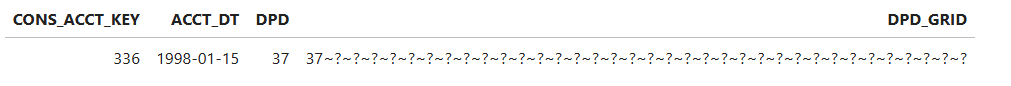

### Case II:
The DPD data for specific **CONST_ACCT_KEY = 337** starts from **1998-02**, contradictory to **336** which starts from **1998-01**
which means that DPD_Summary table already posesses records for **1998-01**, So when the data for **1998-02** is processed it should have DPD_GRID like 
*DPD~?..(36 entities)*

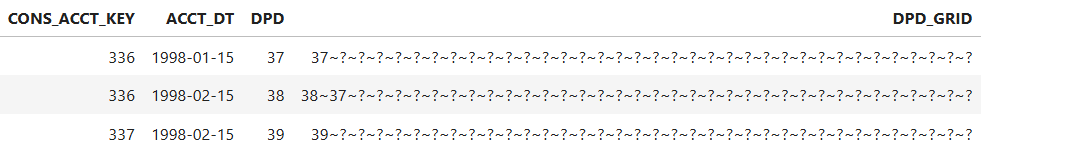

### Case III Prompt

I am trying to process some data from iceberg tables
i have a table dpd_data which holds the following data

CONS_ACCT_KEY,ACCT_DT,DPD
112,1998-01-15,3
112,1998-02-15,5

now I am generating a DPD_GRID (last 36 months data) inside a dpd_summary table

CONS_ACCT_KEY,ACCT_DT,DPD,DPD_GRID
112,1998-01-15,3,3~?~?~?~?..
112,1998-02-15,5~3~?~?~?~?..

if some month data is missing it should be filled with ?

Now the following are the considerations for the execution

Considerations
There is only one DPD per month for each CONS_ACCT_KEY

Scenarios to be followed
Case I:
Intial DPD GRID generation when there are no records in DPD Summary Eg. Consider the below case where CONS_ACCT_KEY = 336 has records starting from 1998-01 then the DPD_GRID for 1998-01 should possess DPD~?.. (36 entities)

Case II:
The DPD data for specific CONST_ACCT_KEY = 337 starts from 1998-02, contradictory to 336 which starts from 1998-01 which means that DPD_Summary table already posesses records for 1998-01, So when the data for 1998-02 is processed it should have DPD_GRID like DPD~?..(36 entities)

The above 2 cases are successfully achieved using the below code

%%time
# Define month range
start_month = datetime.date(1998, 5, 1)
end_month = datetime.date(1998, 5, 1)  # Adjust end date as needed
month = start_month
result_table = "ascenddb2.dpd_summary"
while month <= end_month:
    next_month = (month.replace(day=28) + datetime.timedelta(days=4)).replace(day=1)
    # print(f"Next Month: {next_month}")
    prev_month = (month.replace(day=1) - datetime.timedelta(days=1)).replace(day=1)
    # print(f"Previous Month: {prev_month}")

    print(f"Processing month: {month} ...")

    # Load current month data
    current_df = spark.sql(f"""
        SELECT CONS_ACCT_KEY, ACCT_DT, DPD
        FROM ascenddb2.dpd_data
        WHERE 
        CONS_ACCT_KEY in (336,337)  AND 
        ACCT_DT >= DATE '{month}' AND ACCT_DT < DATE '{next_month}'
    """)

    # Load last month DPD strings
    try:
        prev_df = spark.sql(f"""
                            SELECT CONS_ACCT_KEY, ACCT_DT, DPD, DPD_GRID
                            FROM {result_table}
                            WHERE 
                            CONS_ACCT_KEY in (336,337)  AND 
                            ACCT_DT >= DATE '{prev_month}' AND ACCT_DT < DATE '{month}'
                        """)
    except:
        prev_df = None  # First month case
    if prev_df:
        # Join with previous DPD string
        merged_df = current_df.join(
            prev_df.select("CONS_ACCT_KEY", "DPD_GRID"),
            on="CONS_ACCT_KEY",
            how="left"
        )

        # Merge strings: Append current DPD to previous string
        merged_df = merged_df.withColumn(
            "Merged_DPD_Array",
            F.concat(
                F.array(F.col("DPD")),
                F.when(F.col("DPD_GRID").isNotNull(), F.split(F.col("DPD_GRID"), "~"))
                 .otherwise(F.array())
            )
        )
    else:
        # First month case: No previous data
        merged_df = current_df.withColumn("Merged_DPD_Array", F.array(F.col("DPD")))
    # merged_df.show(truncate=False)
    # Pad with "?" & Keep last 36 months
    max_months = 36
    merged_df = merged_df.withColumn(
        "DPD_Array_Trimmed",
        F.when(
            F.size("Merged_DPD_Array") >= max_months,
            F.slice("Merged_DPD_Array", 1, max_months)
        ).otherwise(
            F.concat(
                F.col("Merged_DPD_Array"),F.array([F.lit("?") for * in range(max*months - 1)])
            )
        )
    ).withColumn(
        "DPD_GRID",
        F.concat_ws("~", "DPD_Array_Trimmed")
    )
    # merged_df.show(truncate=False)

    # Select final columns
    final_df = merged_df.select("CONS_ACCT_KEY", "ACCT_DT", "DPD", "DPD_GRID")

    # Save for next iteration & final output
    # final_df.write.mode("overwrite").saveAsTable(result_table)
    final_df.show(truncate=False)
    # final_df.write\
    #     .format("iceberg")\
    #     .mode("append")\
    #     .saveAsTable("ascenddb2.dpd_summary")

    # Next month
    month = next_month
final_df.explain()
print("✅ Completed incremental DPD string generation!")

However the following scenario is not successfully followed by the code

Case 3
We will be processing the data month by month,
so if the data exists for all months there will be no issues
but when there are records missing in between months
Eg. Lets say that CONS_ACCT_KEY = 336 exists for 1998-01,1998-02,1998-03,1998-05
Now Since we are processing the data month by month there will be no data loss till 1998-03
But once we process the data for 1998-05, as there is no previous month data it will be considered as a record from Case I and fill all **the rest of 35 months as ?**

Instead the data should be 
CONS_ACCT_KEY,ACCT_DT,DPD,DPD_GRID
336,1998-01-15,3,3~?~?~?~?~?~?~?~?~?~?~?~?....
336,1998-02-15,6,6~3~?~?~?~?~?~?~?~?~?~?~?~?....                                           
336,1998-03-15,4,4~6~3~?~?~?~?~?~?~?~?~?~?~?~?....  
336,1998-05-15,5,5~?~4~6~3~?~?~?~?~?~?~?~?~?~?~?~?....                             

In [ ]:
    # if prev_df:
    #     # Join with previous DPD string
    #     merged_df = current_df.join(
    #         prev_df.select("CONS_ACCT_KEY", "DPD_GRID"),
    #         on="CONS_ACCT_KEY",
    #         how="left"
    #     )
        
    #     # Merge strings: Append current DPD to previous string
    #     merged_df = merged_df.withColumn(
    #         "Merged_DPD_Array",
    #         F.concat(
    #             F.array(F.col("DPD")),
    #             F.when(F.col("DPD_GRID").isNotNull(), F.split(F.col("DPD_GRID"), "~"))
    #              .otherwise(F.array())
    #         )
    #     )
    # else:
    #     # First month case: No previous data
    #     merged_df = current_df.withColumn("Merged_DPD_Array", F.array(F.col("DPD")))

In [ ]:
[29, 28, 27, 26, 25, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?]
[29, 28, 27, 26, 25, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?]